In [8]:
import os
import sys
import pylab as p
import pylab as pl
import matplotlib as mpl
import pylab as pl
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import r2_score
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
# Settings for matplotlib
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['pdf.fonttype'] = 42

In [9]:
# Dependency Function Definitions:
def calc_rmsd(x, y):
    if len(x) == 0:
        return 0.0
    chi2 = sum((y - x) ** 2)
    rmsd = np.sqrt(chi2 / len(y))
    return rmsd

def calc_r2(x, y):
    if len(x) == 0:
        return 0.0
    correlation = r2_score(y, x)
    return correlation

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    common = []
    for element in list1:
        if element in list2:
            common.append(element)
    return list(c - d), common

Resonance: C1'
All shifts:    m = 1.02, c = -9.33
Loop shifts:    m = 1.20, c = -27.28
Resonance: C4'
All shifts:    m = 0.67, c = 26.84
Loop shifts:    m = 0.43, c = 47.28
Resonance: C5'
All shifts:    m = 0.67, c = 19.27
Loop shifts:    m = 0.73, c = 14.65
Resonance: C8
All shifts:    m = 1.06, c = -2.94
Loop shifts:    m = 1.20, c = -21.69
Resonance: C6
All shifts:    m = 0.61, c = 56.16
Loop shifts:    m = 1.42, c = -56.71
0.7095972861404563
0.6924782931074234
0.9626062710206955
   res atom  dw_avg  dw_err_avg  predicted_avg_dw  predict_std_dw       err
0   30  C1'   2.315    0.105119          2.244825        1.274255  0.070175
1   31  C1'   2.210    0.100000          1.765382        1.382739  0.444618
4   31  C4'  -1.000    0.049497         -0.665660        1.445906 -0.334340
7   31   C6   1.320    0.040000          0.911594        0.960407  0.408406
2   34  C1'   2.395    0.105119          1.584327        2.746107  0.810673
6   34   C8   2.600    0.200000          3.404663       

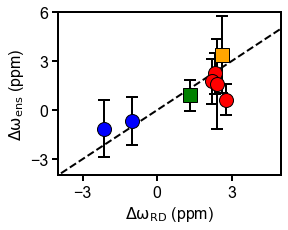

In [20]:
# FARFAR_NMR Ensemble:

dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv").drop_duplicates()
dfp["shift_avg"] = np.nanmean(dfp.iloc[:, 2:], axis=1)
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")
dfd = pd.read_csv("data/ES1_measured_dw.csv").dropna(subset=["dw_avg"])

# Indices of the conformers (relative position in lib)
indices = np.array([332,  367,  636,  683,  686,  997, 1196, 2295, 2615, 2751, 3051, 
                    4151, 4348, 4460, 4793, 4801, 6962, 8322, 9002, 9615], dtype=int)
ES_indices = (indices >= 5000)
GS_indices = (indices < 5000)

# List of resonances & residues to plot for this analysis 
resonances = ["C1'", "C4'", "C5'", "C8", "C6"]
residue_nos = [29, 30, 31, 32, 33, 34, 35, 36]
residue_names = ["C", "C", "U", "G", "G", "G", "A", "G"]

DW_res_no = []
DW_atom = []
DW_avg_predicted = []
DW_std_predicted = []

for resonance in resonances:
    dfp_f = dfp.loc[dfp["atom"] == resonance]
    dfm_f = dfm.loc[dfm["Atom"] == resonance]
    D = dfm_f.merge(dfp_f, left_on=["Resi", "Atom"], right_on=["res", "atom"], how="inner")
    D = D.rename(columns = {'Shift' : 'm_shift_avg', 'SDev': 'm_shift_dev'})
    D = D.drop(columns = ["Resn", "Resi", "Nuc", "Atom"])
    print("Resonance: %s"%(resonance))
    
    #print(D.head(5))
    # measure linear correction using all chemical shifts:
    y = D["m_shift_avg"]
    x = D["shift_avg"]
    m, c = np.polyfit(x, y, 1)
    print("All shifts:    m = %3.2f, c = %3.2f"%(m, c))
    
    # measure linear correction using apical loop shifts:
    D = D.loc[D["res"].isin(residue_nos)]
    y = D["m_shift_avg"]
    x = D["shift_avg"]
    m_, c_ = np.polyfit(x, y, 1)
    print("Loop shifts:    m = %3.2f, c = %3.2f"%(m_, c_))
    
    p_avg = np.mean(D.iloc[:, 4:4+20], axis=1)
    
    if resonance == "C6":
        fake_rows = [ [np.nan]*2 + [32] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [33] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [34] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [35] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [36] + ["C6"] + [np.nan]*21 ]
        D2 = pd.DataFrame(fake_rows, columns = D.columns)
        D = D.append(D2).sort_values(by=["res"])
        
    elif resonance == "C8":
        fake_rows = [ [np.nan]*2 + [29] + ["C8"] + [np.nan]*21, 
                      [np.nan]*2 + [30] + ["C8"] + [np.nan]*21,  
                      [np.nan]*2 + [31] + ["C8"] + [np.nan]*21 ]
        D2 = pd.DataFrame(fake_rows, columns = D.columns)
        D = D.append(D2).sort_values(by=["res"])
        
    # Apply linear correction to all predicted chemical shifts:
    All_pCS = np.array(D.iloc[:, 4:4+20], dtype=float) * m + c
    GS_pCS_avg = np.nan_to_num(np.nanmean(All_pCS[:, GS_indices], axis=1))
    ES_pCS_avg = np.nan_to_num(np.nanmean(All_pCS[:, ES_indices], axis=1))
    GS_pCS_std = np.nan_to_num(np.nanstd(All_pCS[:, GS_indices], axis=1))
    ES_pCS_std = np.nan_to_num(np.nanstd(All_pCS[:, ES_indices], axis=1))
    DW_res_no += residue_nos
    DW_atom += [resonance] * 8
    DW_avg_predicted += (ES_pCS_avg - GS_pCS_avg).tolist()
    std_diff_means = np.sqrt((ES_pCS_std**2)/4 + (GS_pCS_std**2)/16).tolist()
    DW_std_predicted += std_diff_means

df = pd.DataFrame()
df["res"] = DW_res_no
df["atom"] = DW_atom
df["predicted_avg_dw"] = DW_avg_predicted
df["predict_std_dw"] = DW_std_predicted


# merge and filter out residues to plot
df1 = df.merge(dfd, how="inner", on=["res", "atom"]).loc[:, ["res", "atom", "dw_avg", "dw_err_avg", 
                                    "predicted_avg_dw", "predict_std_dw"]].sort_values(by = ["res", "atom"])

#print(df1)

DF = df1
d = DF.copy()
#d = d.loc[~((d.res== 35) & (d.atom == "C1'"))]
rmsd = calc_rmsd(d.dw_avg, d.predicted_avg_dw)
d["err"] = d.dw_avg - d.predicted_avg_dw
#print(d)
r2 = r2_score(d.dw_avg, d.predicted_avg_dw)
print(np.corrcoef(d.dw_avg, d.predicted_avg_dw)[0,1]**2)
print(r2)
print(rmsd)
print(d)
fig, ax = plt.subplots(figsize = (4, 3))
colors = ['red', 'red', 'blue', 'green', 'red', 'orange', 'red', 'blue']
msymbols = ["o", "o", "o", "s", "o", "s", "o", "o"]
for x,y,xerr,yerr,mc,ms in zip(d.dw_avg.tolist(), d.predicted_avg_dw.tolist(), d.dw_err_avg.tolist(), d.predict_std_dw.tolist(), colors, msymbols):
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=ms, markersize=14, elinewidth=2, capthick=2, color=mc, mec='k', ecolor="k", capsize=6, linewidth=2)
ax.plot([-8, 8], [-8,8], color="k", ls="--", lw=2)
ax.set_xlim([-4, 5])
ax.set_ylim([-4, 6])
ax.tick_params(width=2,length=6)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([-3, 0, 3])
ax.set_yticks([-3, 0, 3, 6])
ax.set_ylabel(r"$\Delta{\rm \omega}_{\rm ens}$ (ppm)", fontsize=16)
ax.set_xlabel(r"$\Delta{\rm \omega}_{\rm RD}$ (ppm)", fontsize=16)
#plt.savefig("plots/ensemble_vs_RD_dW_OutlierFixed_Correlation.pdf")

plt.show()

Resonance: C1'
All shifts:    m = 1.02, c = -9.33
Loop shifts:    m = 1.20, c = -27.28
Resonance: C4'
All shifts:    m = 0.67, c = 26.84
Loop shifts:    m = 0.43, c = 47.28
Resonance: C5'
All shifts:    m = 0.67, c = 19.27
Loop shifts:    m = 0.73, c = 14.65
Resonance: C8
All shifts:    m = 1.06, c = -2.94
Loop shifts:    m = 1.20, c = -21.69
Resonance: C6
All shifts:    m = 0.61, c = 56.16
Loop shifts:    m = 1.42, c = -56.71
0.01831668480843429
-0.8539649695801834
2.3635324011247496
   res atom  dw_avg  dw_err_avg  predicted_avg_dw  predict_std_dw       err
0   30  C1'   2.315    0.105119         -0.439106        1.553584  2.754106
1   31  C1'   2.210    0.100000         -0.151753        1.359911  2.361753
4   31  C4'  -1.000    0.049497          0.786366        1.689813 -1.786366
7   31   C6   1.320    0.040000         -0.087760        0.558225  1.407760
2   34  C1'   2.395    0.105119          0.950698        2.016262  1.444302
6   34   C8   2.600    0.200000         -1.291303     

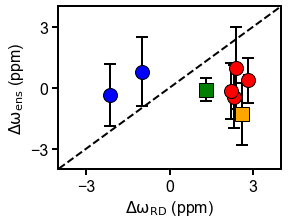

In [23]:
# FARFAR-NMR Randomly (Randomized == Not exactly reproduced)
dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv")
dfp["shift_avg"] = np.nanmean(dfp.iloc[:, 2:], axis=1)
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")
dfd = pd.read_csv("data/ES1_measured_dw.csv").dropna(subset=["dw_avg"])

# List of resonances & residues to plot for this analysis 
resonances = ["C1'", "C4'", "C5'", "C8", "C6"]
residue_nos = [29, 30, 31, 32, 33, 34, 35, 36]
residue_names = ["C", "C", "U", "G", "G", "G", "A", "G"]

N=10
import random
# Rewrite to forloop:
ES_indices_list = []
GS_indices_list = []
for i in range(N):
    np.random.seed(i*720)
    ES_indices_ = np.unique(random.sample(range(0, 20), 4))
    GS_indices_ = np.array([i for i in range(20) if i not in ES_indices_])
    ES_indices_list.append(ES_indices_)
    GS_indices_list.append(GS_indices_)



#print(ES_indices_list)
#print(GS_indices_list)
DW_res_no = []
DW_atom = []
DW_avg_predicted = []
DW_std_predicted = []

for resonance in resonances:
    dfp_f = dfp.loc[dfp["atom"] == resonance]
    dfm_f = dfm.loc[dfm["Atom"] == resonance]
    D = dfm_f.merge(dfp_f, left_on=["Resi", "Atom"], right_on=["res", "atom"], how="inner")
    D = D.rename(columns = {'Shift' : 'm_shift_avg', 'SDev': 'm_shift_dev'})
    D = D.drop(columns = ["Resn", "Resi", "Nuc", "Atom"])
    print("Resonance: %s"%(resonance))
    
    # measure linear correction using all chemical shifts:
    y = D["m_shift_avg"]
    x = D["shift_avg"]
    m, c = np.polyfit(x, y, 1)
    print("All shifts:    m = %3.2f, c = %3.2f"%(m, c))
    
    # measure linear correction using apical loop shifts:
    D = D.loc[D["res"].isin(residue_nos)]
    y = D["m_shift_avg"]
    x = D["shift_avg"]
    m_, c_ = np.polyfit(x, y, 1)
    print("Loop shifts:    m = %3.2f, c = %3.2f"%(m_, c_))
       
    p_avg = np.mean(D.iloc[:, 4:4+20], axis=1)
    
    if resonance == "C6":
        fake_rows = [ [np.nan]*2 + [32] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [33] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [34] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [35] + ["C6"] + [np.nan]*21, 
                      [np.nan]*2 + [36] + ["C6"] + [np.nan]*21 ]
        D2 = pd.DataFrame(fake_rows, columns = D.columns)
        D = D.append(D2).sort_values(by=["res"])
        
    elif resonance == "C8":
        fake_rows = [ [np.nan]*2 + [29] + ["C8"] + [np.nan]*21, 
                      [np.nan]*2 + [30] + ["C8"] + [np.nan]*21,  
                      [np.nan]*2 + [31] + ["C8"] + [np.nan]*21 ]
        D2 = pd.DataFrame(fake_rows, columns = D.columns)
        D = D.append(D2).sort_values(by=["res"])
        
    # Apply linear correction to all predicted chemical shifts:
    All_pCS = np.array(D.iloc[:, 4:4+20], dtype=float) * m + c
    
    # rewrite to for loop:
    for i in range(N):
        if i == 0:
            GS_pCS_avg = np.nan_to_num(np.nanmean(All_pCS[:, GS_indices_list[0]], axis=1))
            ES_pCS_avg = np.nan_to_num(np.nanmean(All_pCS[:, ES_indices_list[0]], axis=1))
            GS_pCS_std = np.nan_to_num(np.nanstd(All_pCS[:, GS_indices_list[0]], axis=1))
            ES_pCS_std = np.nan_to_num(np.nanstd(All_pCS[:, ES_indices_list[0]], axis=1))
        else:
            GS_pCS_avg += np.nan_to_num(np.nanmean(All_pCS[:, GS_indices_list[i]], axis=1))
            ES_pCS_avg += np.nan_to_num(np.nanmean(All_pCS[:, ES_indices_list[i]], axis=1))
            GS_pCS_std += np.nan_to_num(np.nanstd(All_pCS[:, GS_indices_list[i]], axis=1))
            ES_pCS_std += np.nan_to_num(np.nanstd(All_pCS[:, ES_indices_list[i]], axis=1))
    
    GS_pCS_avg = GS_pCS_avg/N
    ES_pCS_avg = ES_pCS_avg/N
    GS_pCS_std = GS_pCS_std/N
    ES_pCS_std = ES_pCS_std/N

    DW_res_no += residue_nos
    DW_atom += [resonance] * 8
    DW_avg_predicted += (ES_pCS_avg - GS_pCS_avg).tolist()
    std_diff_means = np.sqrt((ES_pCS_std**2)/4 + (GS_pCS_std**2)/16).tolist()
    DW_std_predicted += std_diff_means

df = pd.DataFrame()
df["res"] = DW_res_no
df["atom"] = DW_atom
df["predicted_avg_dw"] = DW_avg_predicted
df["predict_std_dw"] = DW_std_predicted


# merge and filter out residues to plot
rand_df3 = df.merge(dfd, how="inner", on=["res", "atom"]).loc[:, ["res", "atom", "dw_avg", "dw_err_avg", 
                                    "predicted_avg_dw", "predict_std_dw"]].sort_values(by = ["res", "atom"])

DF = rand_df3
d = DF.copy()
rmsd = calc_rmsd(d.dw_avg, d.predicted_avg_dw)
r2 = r2_score(d.dw_avg, d.predicted_avg_dw)
print(np.corrcoef(d.dw_avg, d.predicted_avg_dw)[0,1]**2)
print(r2)
print(rmsd)
d["err"] = d.dw_avg - d.predicted_avg_dw
print(d)

fig, ax = plt.subplots(figsize = (4, 3))
colors = ['red', 'red', 'blue', 'green', 'red', 'orange', 'red', 'blue']
msymbols = ["o", "o", "o", "s", "o", "s", "o", "o"]
for x,y,xerr,yerr,mc,ms in zip(d.dw_avg.tolist(), d.predicted_avg_dw.tolist(), d.dw_err_avg.tolist(), d.predict_std_dw.tolist(), colors, msymbols):
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=ms, markersize=14, elinewidth=2, capthick=2, color=mc, mec='k', ecolor="k", capsize=6, linewidth=2)
ax.plot([-8, 8], [-8,8], color="k", ls="--", lw=2)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.tick_params(width=2,length=6)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([-3, 0, 3])
ax.set_yticks([-3, 0, 3])
ax.tick_params(width=2,length=6)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel(r"$\Delta{\rm \omega}_{\rm ens}$ (ppm)", fontsize=16)
ax.set_xlabel(r"$\Delta{\rm \omega}_{\rm RD}$ (ppm)", fontsize=16)
#plt.savefig("plots/FINAL_ensemble_vs_RD_dw_wtTARRandomPartitionEnsemble_Orca5_Correlation.pdf")

plt.show()